# 1. Assessing the data

## 1.1 Import the Data

Using pandas, I start by reading the csv files, obtaining the x and y data sets. Some notable challenges imposed by this dataset including
- Some of the data columns are not numerical values, and as such they must be converted to numerical values in order to be useful for training any ML model
- The data is not normalized. As such, learning algorithms that depend on the closeness of data points in different dimmensions will be effected unless the training data is normalized


In [9]:
import pandas as pd

#function to import the training data
def import_train_data(file_name, y_header, normalize = True):
    
    #read the data into a csv
    df = pd.read_csv(file_name)
    
    #get the column headers
    col_headers = df.columns.values.tolist()
    
    #identify the index of the y_header
    y_header_idx = col_headers.index(y_header)
    
    #get the x headers
    x_headers = col_headers.copy()
    x_headers.pop(y_header_idx)
    
    #get the x values
    df_x = df.loc[:,x_headers]
    df_y = df.loc[:,y_header]
    
    # convert data to numerical data
    col_data_conversions = get_col_data_conversions(df_x)
    df_x = apply_col_data_conversions(df_x,col_data_conversions)
    
    if normalize:
        max_vals,min_vals = get_normalization_coeffs(df_x)
        df_x = apply_normalization_coeffs(df_x,max_vals,min_vals)
    else:
        min_vals = []
        max_vals = []
    
    return df_x,df_y,col_data_conversions,min_vals,max_vals

def import_test_data(file_name, col_data_conversions, normalize = True, min_vals = [], max_vals = []):
    """import the test data for the Kaggle submission

    Args:
        file_name (_type_): the name of the file that the test data is stored in
        col_data_conversions (_type_): the column data conversions generated from the training dataset
        normalize (bool, optional): normalizes the data on true. Defaults to True.
        min_vals (list, optional): list of minimum values used for normalization. Defaults to [].
        max_vals (list, optional): list of maximum values used for normalization. Defaults to [].

    Returns:
        _type_: a data frame of the inputs from the test
    """
    #read the data into a csv
    df_x = pd.read_csv(file_name)
    
    # convert data to numerical data
    df_x = apply_col_data_conversions(df_x,col_data_conversions)
    
    if normalize:
        df_x = apply_normalization_coeffs(df_x,max_vals,min_vals)
    
    return df_x

def save_y_test_to_file(y_test,file_name):
    """Save the predicted values from the test set to a csv file for submission

    Args:
        y_test (_type_): an N x 1 numpy array with the predictions from x_test
        file_name (_type_): the name of the submission file
    """
    df = pd.DataFrame(data=y_test,dtype=int)
    df.columns = ["Predicted"]
    df.to_csv(file_name,index_label="Id")

def convert_y_vals(data_frame, as_int = True):
    """Convert the y values from "Yes" and "No" to 1 and 0 respectively

    Args:
        data_frame (_type_): _description_
    """
    num_rows = data_frame.shape[0]
    if as_int:
        for i in range(num_rows):
            if data_frame.iloc[i] == "Yes":
                data_frame.iloc[i] = 1
            else:
                data_frame.iloc[i] = 0
    else:
        for i in range(num_rows):
            if data_frame.iloc[i] == "Yes":
                data_frame.iloc[i] = 1.0
            else:
                data_frame.iloc[i] = 0.0

def get_col_data_conversions(data_frame):
    """Some columns have data that are not integers, the function returns a list of dictionaries that can then be used to convert the non-numeric data values to numeric values

    Args:
        data_frame (_type_): a pandas data frame

    Returns:
        _type_: list of dictionaries where non-empty dictionaries contain key:value pairs to convert between non-numeric data to numeric data
    """
    
    
    #get the column data types
    col_types = data_frame.dtypes

    #get the shape of the data frame
    num_cols = data_frame.shape[1]
    num_rows = data_frame.shape[0]
    
    #initialize a list of empty dictionaries that will hold the data conversions if needed
    col_data_conversions = [{}] * num_cols
    for i in range(num_cols):
        if col_types.iloc[i] != "int64":
            cur_label = 0
            data_conversions= {}
            for j in range(num_rows):
                if data_frame.iloc[j,i] not in data_conversions:
                    data_conversions[data_frame.iloc[j,i]] = cur_label
                    cur_label = cur_label + 1
            col_data_conversions[i] = data_conversions.copy()

    #return the list of dictionaries with data conversions
    return col_data_conversions

def apply_col_data_conversions(data_frame,col_data_conversions):
    """Apply the given column data frame conversions to the data frame

    Args:
        data_frame (_type_): a pandas data frame to apply the data conversions to
        col_data_conversions (_type_): the data conversions to apply

    Returns:
        _type_: a copy of the pandas data frame where all non-numeric entries have been converted to numeric entries
    """
    
    #get the shape of the data frame
    num_cols = data_frame.shape[1]
    num_rows = data_frame.shape[0]

    ret_df = data_frame.copy()
    for i in range(num_cols):
        if len(col_data_conversions[i]) != 0:
            for j in range(num_rows):
                
                #just in case this is an unseen value with no conversion
                if data_frame.iloc[j,i] not in col_data_conversions[i]:
                    val = len(col_data_conversions[i].keys)
                    col_data_conversions[i][data_frame.iloc[j,i]] = val
                
                #change the value
                ret_df.iloc[j,i] = col_data_conversions[i][data_frame.iloc[j,i]]
    
    return ret_df

def get_normalization_coeffs(data_frame):
    """returns a list of maximum and minimum values for each column in the data frame so that the data can be normalized

    Args:
        data_frame (_type_): a pandas data frame

    Returns:
        _type_: max_vals,min_vals - lists of the maximum and minimum values for each data frame
    """
    
    #get the shape of the data frame
    num_cols = data_frame.shape[1]
    num_rows = data_frame.shape[0]
    
    max_vals = [0] * num_cols
    min_vals = [0] * num_cols
    
    for i in range(num_cols):
        max_vals[i] = data_frame.iloc[:,i].max()
        min_vals[i] = data_frame.iloc[:,i].min()
    
    return max_vals,min_vals

def apply_normalization_coeffs(data_frame,max_vals,min_vals):
    """Apply the normalization coefficients, if all values are the same, then the whole column is set to 1

    Args:
        data_frame (_type_): a pandas data frame
        max_vals (_type_): a list of max values for each column
        min_vals (_type_): a list of min values for each column

    Returns:
        _type_: _description_
    """
    #get the shape of the data frame
    num_cols = data_frame.shape[1]
    num_rows = data_frame.shape[0]

    ret_df = data_frame.copy()
    for i in range(num_cols):
        max_val = max_vals[i]
        min_val = min_vals[i]
        diff = float(max_val - min_val)
        
        if diff == 0:
            for j in range(num_rows):
                ret_df.iloc[j,i] = 1
        else:
            for j in range(num_rows):
                ret_df.iloc[j,i] = float(data_frame.iloc[j,i] - min_val)/diff
    
    return ret_df


#print the headers from the data frame
#col_headers = df.columns.values.tolist()
normalize_data = True
df_x_train,df_y_train,col_data_conversions,min_vals_train,max_vals_train = import_train_data("train.csv","Attrition",normalize=normalize_data)

#convert the y values to 0 and 1
convert_y_vals(df_y_train)

#import the test data set for submissions in the future
df_x_test = import_test_data("test.csv",col_data_conversions,normalize=normalize_data,min_vals=min_vals_train,max_vals=max_vals_train)

#save the feature labels in an array for future reference
feature_labels = df_x_train.columns.values.tolist()


## 1.2 Analyze the given training dataset and its respective features


Feature Labels with best AUCs

Feature: TotalWorkingYears, AUC = 0.2352059519295014
Feature: Age, AUC = 0.2511015403506871
Feature: YearsAtCompany, AUC = 0.2557876013507413
Feature: MonthlyIncome, AUC = 0.2678187695252542
Feature: YearsInCurrentRole, AUC = 0.2843779908626325



Feature Labels with worst AUCs

Feature: Over18, AUC = 0.5
Feature: StandardHours, AUC = 0.5
Feature: EmployeeCount, AUC = 0.5
Feature: EducationField, AUC = 0.5023340014807591
Feature: Gender, AUC = 0.5120401971937809


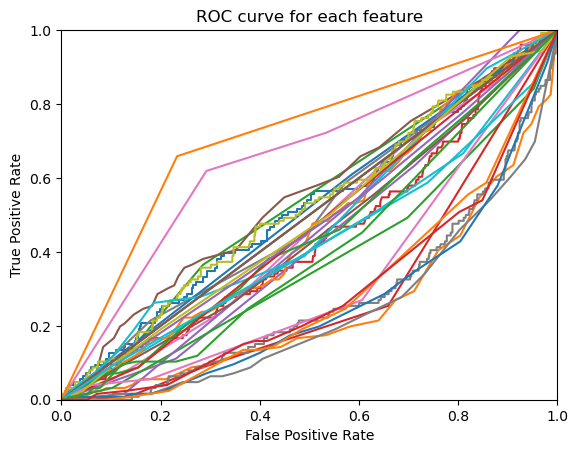

In [3]:
#generate ROC curves for all of the features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def compute_feature_AUCs(df_x,df_y,plot_ROCs = True):
    """Computes the AUC for each feature with the option of plotting the ROC curves as well

    Args:
        df_x (_type_): a pandas data frame of input values
        df_y (_type_): a pandas data frame of output values
        plot_ROCs (bool, optional): plots the ROC for each feature on true. Defaults to True.

    Returns:
        _type_: a numpy list of the AUC for each feature
    """
    
    #access the x and y data sets
    X = df_x.to_numpy(dtype=float)
    y = df_y.to_numpy(dtype=float)

    #split the data into 80% training and 20% testing with random state to 2022
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=2022)

    num_features = np.shape(X)[1]
    feature_AUCs = np.zeros(num_features)

    #initialize the plot
    if plot_ROCs:
        fig,ax = plt.subplots()
        for i in range(num_features):
            fpr,tpr,thresholds = roc_curve(y_train,X_train[:,i])
            feature_AUCs[i] = auc(fpr,tpr)
            ax.plot(fpr,tpr)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_title("ROC curve for each feature")
    else:
       for i in range(num_features):
            fpr,tpr,thresholds = roc_curve(y_train,X_train[:,i])
            feature_AUCs[i] = auc(fpr,tpr) 
    
    return feature_AUCs

def print_best_AUC_features(df_X,df_y,num_to_print = 5):
    """Prints a list of the features with the best AUCs

    Args:
        df_x (_type_): a pandas data frame of input values
        df_y (_type_): a pandas data frame of output values

    Returns:
        _type_: a sorted list of feature indicies by the best AUCs
    """
    
    feature_labels = df_X.columns.values.tolist()
    
    feature_AUCs = compute_feature_AUCs(df_X,df_y,plot_ROCs=False)

    #get the best feature indicies
    best_AUC_indicies = np.flip(np.argsort(np.absolute(np.subtract(feature_AUCs,0.5))))

    #get print the best AUC's
    print("Feature Labels with best AUCs\n")
    for i in range(num_to_print):
        idx = best_AUC_indicies[i]
        out_str = "Feature: {}, AUC = {}".format(feature_labels[idx],feature_AUCs[idx])
        print(out_str)
    
    return best_AUC_indicies

def print_worst_AUC_features(df_X,df_y,num_to_print = 5):
    """Prints a list of the features with the best AUCs

    Args:
        df_x (_type_): a pandas data frame of input values
        df_y (_type_): a pandas data frame of output values

    Returns:
        _type_: a sorted list of feature indicies by the best AUCs
    """
    
    feature_labels = df_X.columns.values.tolist()
    
    feature_AUCs = compute_feature_AUCs(df_X,df_y,plot_ROCs=False)

    #get the best feature indicies
    worst_AUC_indicies = np.argsort(np.absolute(np.subtract(feature_AUCs,0.5)))

    #get print the best AUC's
    print("Feature Labels with worst AUCs\n")
    for i in range(num_to_print):
        idx = worst_AUC_indicies[i]
        out_str = "Feature: {}, AUC = {}".format(feature_labels[idx],feature_AUCs[idx])
        print(out_str)
    
    return worst_AUC_indicies

feature_AUCs = compute_feature_AUCs(df_x_train,df_y_train,plot_ROCs=True)
best_AUC_indicies = print_best_AUC_features(df_x_train,df_y_train,5)
print("\n\n")
worst_AUC_indicies = print_worst_AUC_features(df_x_train,df_y_train,5)

#res_list = [test_list[i] for i in index_list]

# 2 Models

## 2.0.1 Support Functions

To start, I declare a set of support functions that I can use to trian models, generate ROC curves, perform cross-validation, and perform hyper-parameter tuning

In [72]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

def tune_hyperparams_with_k_fold(clf,X_train,X_test,y_train,y_test,param_grid,convert_to_bool = False,scoring_method = "f1"):

    #perform hyper parameter tuning using sklearn cross validation techniques
    cv = KFold(n_splits=10,random_state=2020,shuffle=True)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring_method, cv=cv)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_

    results_df = pd.DataFrame(search.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    display(results_df[["params", "rank_test_score", "mean_fit_time","mean_test_score", "std_test_score"]])

    #train the best estimator on the test data set
    model = best_clf.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    if convert_to_bool:
        y_pred = (np.sign(y_pred)+1)/2
        #y_pred = (np.sign(y_pred)-1)/-2

    f_1 = metrics.f1_score(y_test,y_pred)
    out_str = "f1 (best estimator on training set): {:0.2}%".format(f_1)
    print(out_str)

    return best_clf

def sweep_hyper_param_vals(clf,X_train,X_test, y_train, y_test, hyperparam_name,vals_to_test,log_scale = False,convert_to_bool=False):

    test_accuracies = np.zeros(np.shape(vals_to_test))
    train_accuracies = np.zeros(np.shape(vals_to_test))

    for i in range(np.size(vals_to_test)):
        #clf = AdaBoostClassifier(n_estimators=50,learning_rate=vals_to_test[i])
        params = {hyperparam_name:vals_to_test[i]}
        clf.set_params(**params)
        model = clf.fit(X_train,y_train)

        #compute predictions
        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)
        
        
        if convert_to_bool:
            y_train_predict = (np.sign(y_train_predict)+1)/2
            #y_train_predict = (np.sign(y_train_predict)-1)/-2
            y_test_predict = (np.sign(y_test_predict)+1)/2
            #y_test_predict = (np.sign(y_test_predict)-1)/-2

        #record predictions
        train_accuracies[i] = metrics.f1_score(y_train,y_train_predict)
        test_accuracies[i] = metrics.f1_score(y_test,y_test_predict)
    
    fig,ax = plt.subplots()
    ax.plot(vals_to_test,test_accuracies,label = "Test F1")
    ax.plot(vals_to_test,train_accuracies,label = "Train F1")
    x_label = hyperparam_name + " values"
    ax.set_xlabel(x_label)
    
    #set log scale if desired
    if log_scale:
        ax.set_xscale("log")
    
    #continue setting other parameters
    ax.set_ylabel("F1")
    title = "F1 vs " + hyperparam_name + " Value"
    ax.set_title(title)
    ax.legend()

def plot_ROC_curves(clf,X_train,X_test,y_train,y_test):
    
    #for training set
    model = clf.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)

    #for test set
    y_test_pred = model.predict(X_test)

    #plot the ROC curve and save the AUC value
    fig,ax = plt.subplots()

    #plot training ROC
    fpr,tpr,thresholds = roc_curve(y_train,y_train_pred)
    train_auc = auc(fpr,tpr)
    ax.plot(fpr,tpr,label = "Training Set")

    fpr,tpr,thresholds = roc_curve(y_test,y_test_pred)
    test_auc = auc(fpr,tpr)
    ax.plot(fpr,tpr,label = "Test Set")
        
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title("ROC curve for best model")
    ax.legend()

    #report test and train AUC
    out_str = "Test AUC: {} Train AUC: {}".format(test_auc,train_auc)
    print(out_str)

def plot_ROC_curves_sklearn(clf,X_train,X_test,y_train,y_test):
    #for training set
    model = clf.fit(X_train,y_train)

    fig,fig_ax= plt.subplots()
    RocCurveDisplay.from_estimator(clf,X_train,y_train,ax=fig_ax)
    RocCurveDisplay.from_estimator(clf,X_test,y_test, ax=fig_ax)
    plt.title("ROC curve for best model")
    plt.show()


## 2.1 Using Adaboost Classification

### 2.1.1 Training a simple Adaboost classifier

In [49]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#load the x data
X = df_x_train.to_numpy(dtype=float)
y = df_y_train.to_numpy(dtype=float)

#split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=2020)

#create the classifier

# Create adaboost classifer object
clf = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

# Train Adaboost Classifer
model = clf.fit(X_train, y_train)


#Predict the response for test dataset
y_pred = model.predict(X_test)

f_1 = metrics.f1_score(y_test,y_pred)
out_str = "f1: {:0.2}%".format(f_1)
print(out_str)

f1: 0.61%


### 2.1.2 Performing Hyper Parameter Tuning using k-fold cross validation

In [50]:
#load the x data
X = df_x_train.to_numpy(dtype=float)
y = df_y_train.to_numpy(dtype=float)

#split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=2020)


# Create adaboost classifer object
clf = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)



param_grid = [
    {"n_estimators": [40,50,60], "learning_rate": [1]},
    {"n_estimators": [50], "learning_rate": [0.5,1,2]}
]

tune_hyperparams_with_k_fold(clf,X_train,X_test,y_train,y_test,param_grid)

,params,rank_test_score,mean_fit_time,mean_test_score,std_test_score
0,"{'learning_rate': 1, 'n_estimators': 40}",1,0.053792,0.655882,0.105998
2,"{'learning_rate': 1, 'n_estimators': 60}",2,0.081417,0.654060,0.139062
1,"{'learning_rate': 1, 'n_estimators': 50}",3,0.067586,0.643747,0.123198
4,"{'learning_rate': 1, 'n_estimators': 50}",3,0.067712,0.643747,0.123198
3,"{'learning_rate': 0.5, 'n_estimators': 50}",5,0.067445,0.606518,0.116384
5,"{'learning_rate': 2, 'n_estimators': 50}",6,0.067651,0.277226,0.120839


f1 (best estimator on training set): 0.66%


AdaBoostClassifier(learning_rate=1, n_estimators=40)

### 2.1.3 Generate a plot for f1 vs hyperparameters of interest


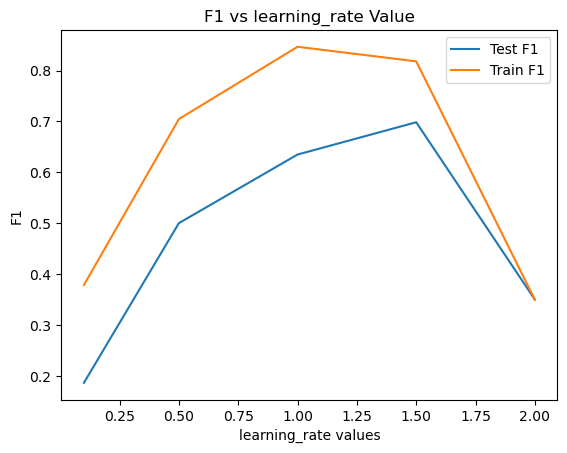

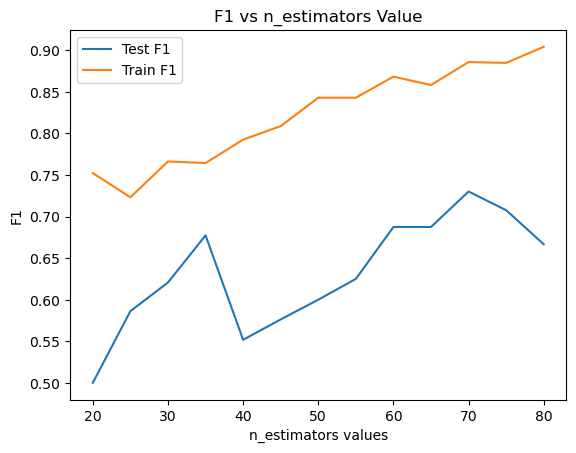

In [51]:
#sweep over learning rates
vals_to_test = np.array([0.1,0.5,1,1.5,2])
hyperparam_name = "learning_rate"
clf = AdaBoostClassifier(n_estimators=50)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

#sweep over n_estimators
vals_to_test = np.array([20,25,30,35,40,45,50,55,60,65,70,75,80])
hyperparam_name = "n_estimators"
clf = AdaBoostClassifier(learning_rate=1.25)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

### 2.1.4 Generate ROC curve for best model

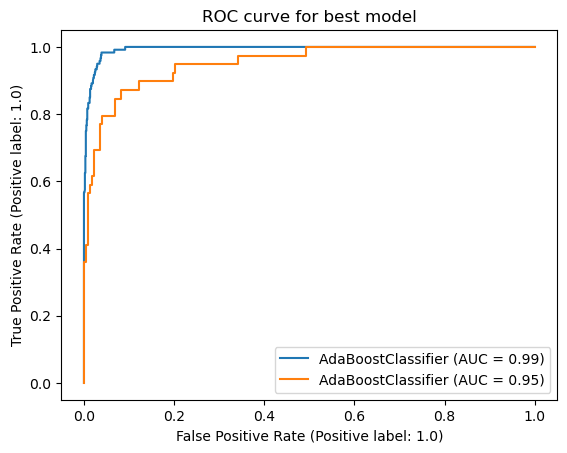

In [53]:
# plot the test and train ROC for f on the same figure
best_ada_boost = AdaBoostClassifier(learning_rate=1.25,n_estimators=60)
plot_ROC_curves_sklearn(best_ada_boost,X_train,X_test,y_train,y_test)

### 2.1.4 Submit Adaboost best model to kaggle

In [54]:
X_test = df_x_test.to_numpy(dtype=float)

#fit the best predicted model
clf = AdaBoostClassifier(learning_rate=1.25,n_estimators=60)
model = clf.fit(X,y)
y_pred = model.predict(X_test)

#f_1 = metrics.f1_score(y_test,y_pred)
#out_str = "f1: {:0.2}%".format(f_1)
save_y_test_to_file(y_pred,"submission.csv")

#achieved a score of 0.62 

## 2.2 Attempting to use Random Forest Classifier

### 2.2.1 Training using a simple random forest classifier

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#load the x data
X = df_x_train.to_numpy(dtype=float)
y = df_y_train.to_numpy(dtype=float)

#split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=2020)

#create the classifier

# Create adaboost classifer object
clf = RandomForestClassifier(n_estimators=400)

# Train Adaboost Classifer
model = clf.fit(X_train, y_train)


#Predict the response for test dataset
y_pred = model.predict(X_test)

f_1 = metrics.f1_score(y_test,y_pred)
out_str = "f1: {:0.2}%".format(f_1)
print(out_str)

f1: 0.32%


### 2.2.3 Perform a sweep over specific hyper parameters

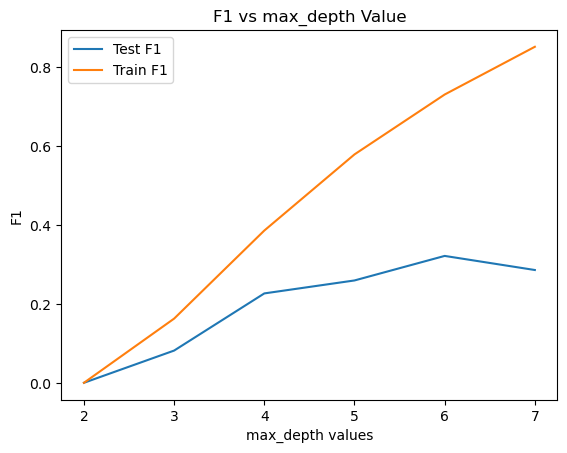

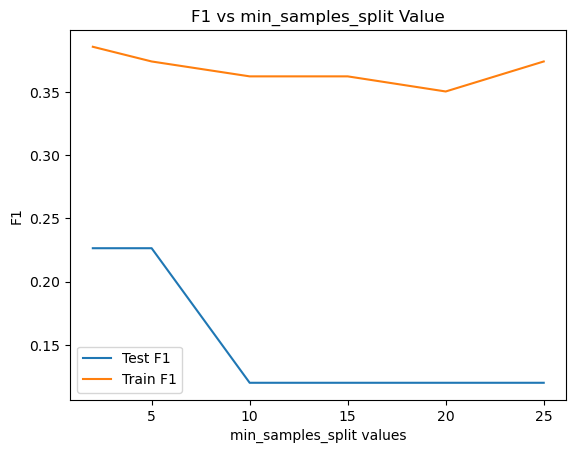

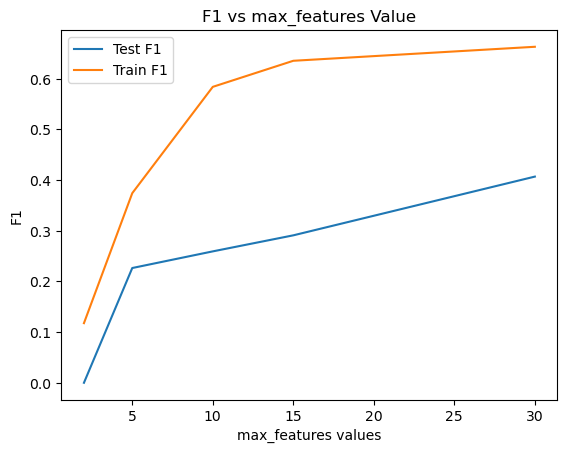

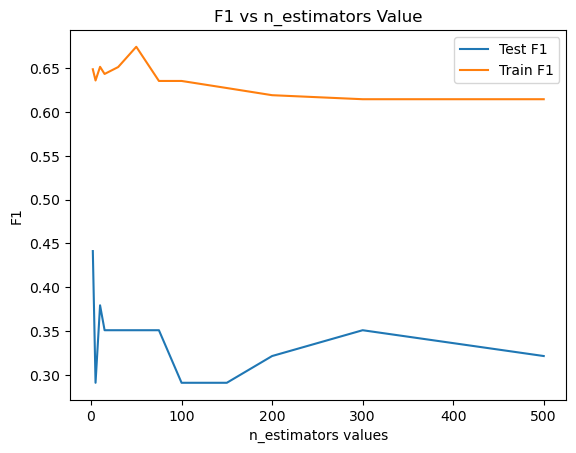

In [111]:
#sweep over maximum depth
vals_to_test = np.array([2,3,4,5,6,7])
hyperparam_name = "max_depth"
clf = RandomForestClassifier(n_estimators=100,random_state=2020)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

#sweep over n_estimators
vals_to_test = np.array([2,5,10,15,20,25])
hyperparam_name = "min_samples_split"
clf = RandomForestClassifier(n_estimators=100,max_depth = 4,random_state=2020)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)


#sweep over n_estimators
vals_to_test = np.array([2,5,10,15,30])
hyperparam_name = "max_features"
clf = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=4,random_state=2020)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

#sweep over n_estimators
vals_to_test = np.array([2,5,10,15,30,50,75,100,150,200,300,500])
hyperparam_name = "n_estimators"
clf = RandomForestClassifier(min_samples_split=5,max_depth=4,max_features=15,random_state=2020)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

## 2.3 Decision Trees

### 2.3.1 Generate a simple deicision tree classifier

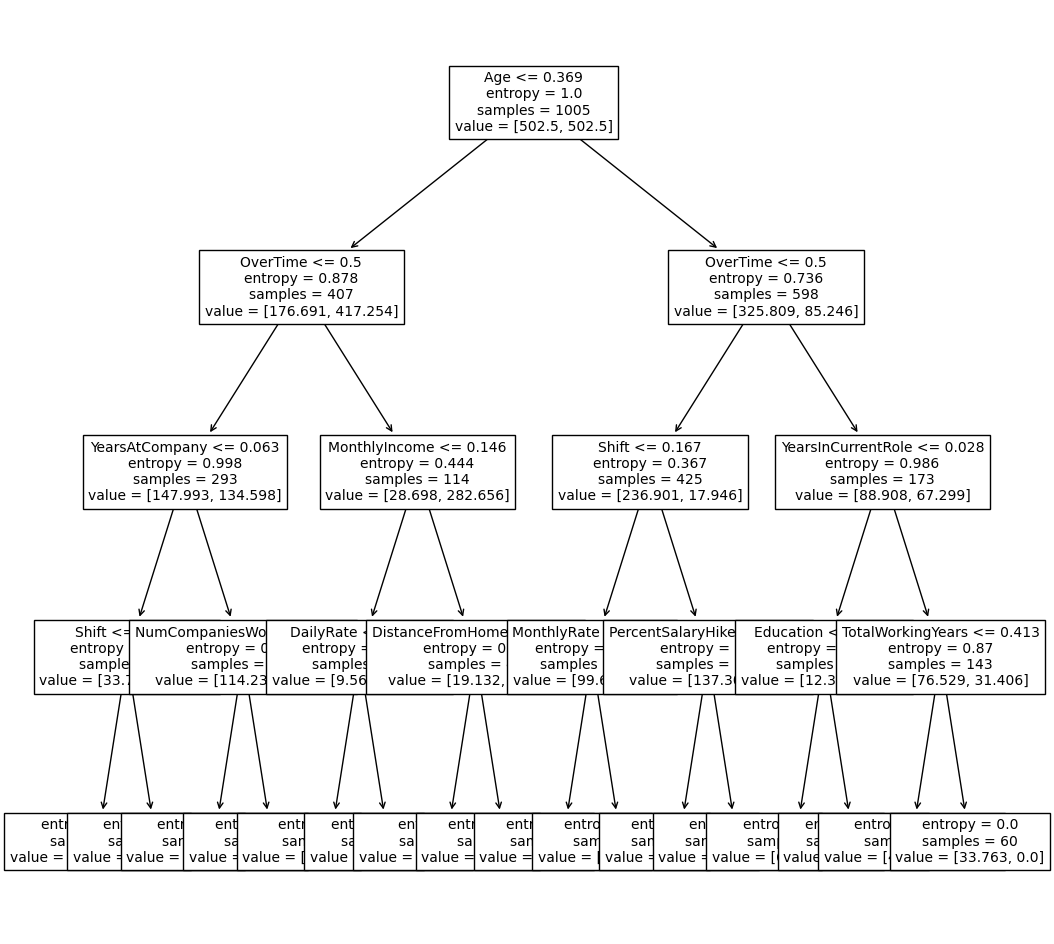

f1: 0.5%


In [128]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

#load the x data
X = df_x_train.to_numpy(dtype=float)
y = df_y_train.to_numpy(dtype=float)

#split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=2020)

#create the classifier

# Create adaboost classifer object
clf = DecisionTreeClassifier(criterion="entropy",max_depth=4,min_samples_leaf=5,random_state=2020,class_weight="balanced")

# Train Adaboost Classifer
model = clf.fit(X_train, y_train)


#Predict the response for test dataset
y_pred = model.predict(X_test)

#plot the tree
feature_labels = df_x_train.columns.values.tolist()
plt.figure(figsize=(12,12))
plot_tree(model,feature_names=feature_labels,fontsize=10)
plt.show()

f_1 = metrics.f1_score(y_test,y_pred)
out_str = "f1: {:0.2}%".format(f_1)
print(out_str)

### 2.3.2 Evaluate hyper parameters using k-fold cross validation

In [140]:
#load the x data
X = df_x_train.to_numpy(dtype=float)
y = df_y_train.to_numpy(dtype=float)

#split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=2020)


# Create adaboost classifer object
clf = DecisionTreeClassifier()


param_grid = [
    {"criterion":["entropy"],"max_depth": [3,4,5], "min_samples_leaf": [1,5,10,20],"min_samples_split":[2,10,20]},
]

best_decision_tree = tune_hyperparams_with_k_fold(clf,X_train,X_test,y_train,y_test,param_grid)
print(best_decision_tree)

,params,rank_test_score,mean_fit_time,mean_test_score,std_test_score
20,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",1,0.003309,0.541953,0.114512
19,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",1,0.003313,0.541953,0.114512
18,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",1,0.003308,0.541953,0.114512
14,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",4,0.003358,0.536759,0.097663
35,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",5,0.003555,0.535146,0.075383
33,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",5,0.003568,0.535146,0.075383
34,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",5,0.003577,0.535146,0.075383
15,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",8,0.003337,0.534378,0.098814
13,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",8,0.003362,0.534378,0.094713
17,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",8,0.003343,0.534378,0.098814


f1 (best estimator on training set): 0.46%
DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=10)


### 2.3.3 Tuning Hyper Parameters using sweeps

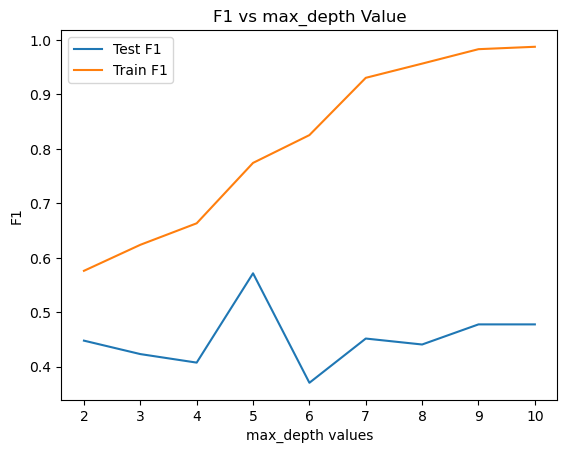

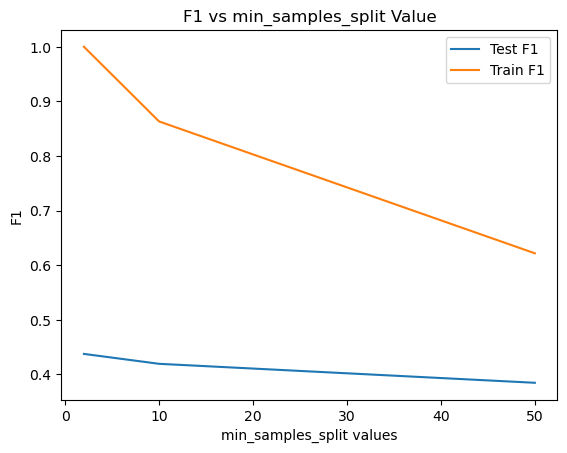

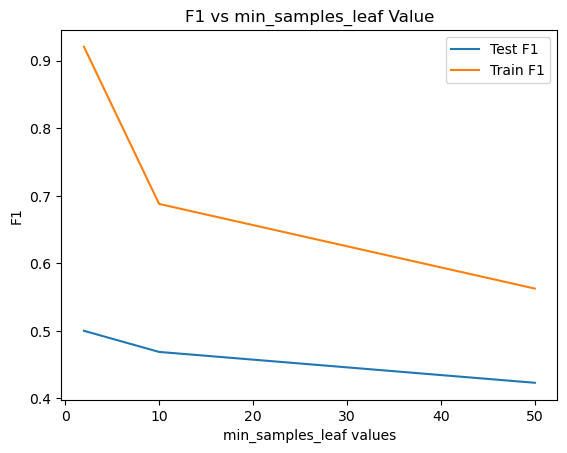

In [137]:
#sweep over max depth
vals_to_test = np.array([2,3,4,5,6,7,8,9,10])
hyperparam_name = "max_depth"
clf = DecisionTreeClassifier(random_state=2020)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

#sweep over min samples to split
vals_to_test = np.array([2,10,50])
hyperparam_name = "min_samples_split"
clf = DecisionTreeClassifier(random_state=2020)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

#sweep over min_samples_leaf
vals_to_test = np.array([2,10,50])
hyperparam_name = "min_samples_leaf"
clf = DecisionTreeClassifier(random_state=2020)
sweep_hyper_param_vals(clf,X_train,X_test,y_train,y_test, hyperparam_name,vals_to_test,log_scale=False)

### 2.3.4 Generate ROC curve for the best model


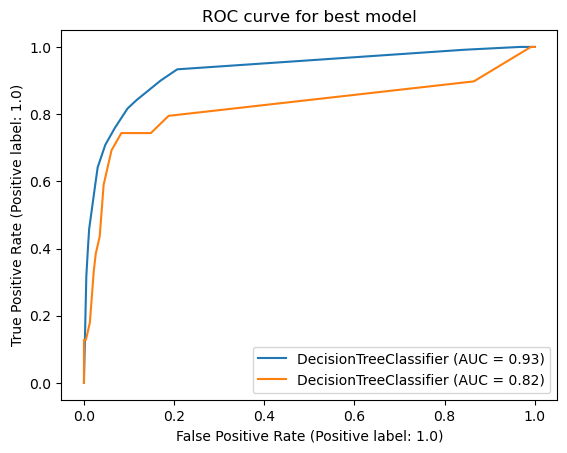

In [141]:
# plot the test and train ROC for f on the same figure
best_decision_tree = DecisionTreeClassifier(criterion="entropy",max_depth=4,min_samples_leaf=10)
plot_ROC_curves_sklearn(best_decision_tree,X_train,X_test,y_train,y_test)